In [1]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [2]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [3]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [4]:
####### load data #######

name = 'd_vp'
id_col = "Id"
target_col = "WnvPresent"
drop_col = "NumMosquitos"

train_name = './d_vp_wo_num/train_{}.csv'.format(name)
test_name = './d_vp_wo_num/test_{}.csv'.format(name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)
test_df = test_df.drop([drop_col], axis=1)

print(df.head())
print(df.shape)

print(test_df.head())
print(test_df.shape)

         Date                                  Address  \
0  2007-05-29  1100 South Peoria Street, Chicago, I...   
1  2013-09-12  1300 North Laramie Avenue, Chicago, ...   
2  2011-09-23  3500 West 51st Street, Chicago, IL 6...   
3  2013-08-22                         Chicago, IL, USA   
4  2007-08-15        West 37th Place, Chicago, IL, USA   

                  Species  Block                   Street  Trap  \
0          CULEX RESTUANS     11              S PEORIA ST  T091   
1           CULEX PIPIENS     13            N LARAMIE AVE  T230   
2  CULEX PIPIENS/RESTUANS     35                W 51ST ST  T062   
3  CULEX PIPIENS/RESTUANS     43   N ASHLAND AVE OVERPASS  T145   
4           CULEX PIPIENS     81               W 37TH PL.  T157   

                    AddressNumberAndStreet   Latitude  Longitude  \
0           1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860   
1         1300  N LARAMIE AVE, Chicago, IL  41.904194 -87.756155   
2             3500  W 51ST ST, Chicago, IL  

[0 1]


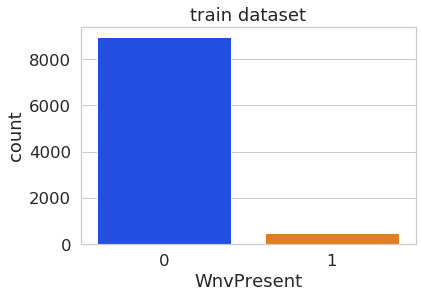

In [5]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [6]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=360)

[BinaryClassificationDataset(target: WnvPresent) 9,455 rows, 11 columns]


Training Dataset size,"(9455, 10)"
Validation Dataset size,None
CV,5
Target variable,WnvPresent
Optimization Metric,roc_auc
Initial number of Features,10
Selected number of Features,11
Selected Features,"[Date, Address, Species, Street, Trap, AddressNumberAndStreet, Latitude, Longitude, Date__month, Date__day, Date__weekday]"
Selected Algorithm,LGBMClassifier
End-to-end Elapsed Time (seconds),213.1
Selected Hyperparameters,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 252, 'num_leaves': 189, 'reg_alpha': 0.052007864628126614, 'reg_lambda': 0.9999875000000014}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,LGBMClassifier_HT,9455,11,0.9222,"{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 252, 'num_leaves': 189, 'reg_alpha': 0.053372077771895864, 'reg_lambda': 0.9999875000000014, 'class_weight': 'balanced'}",11.9817
3,LGBMClassifier_HT,9455,11,0.9219,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 189, 'reg_alpha': 0, 'reg_lambda': 0.9999875000000014}",2.5547
4,LGBMClassifier_HT,9455,11,0.9218,"{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 252, 'num_leaves': 189, 'reg_alpha': 0.053372077771895864, 'reg_lambda': 0.999990000000001, 'class_weight': 'balanced'}",11.6866
5,LGBMClassifier_HT,9455,11,0.9218,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.10351931771562556, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 189, 'reg_alpha': 0, 'reg_lambda': 1}",2.6372
6,LGBMClassifier_HT,9455,11,0.9217,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 189, 'reg_alpha': 0, 'reg_lambda': 0.9999887500000012}",2.5689
...,...,...,...,...,...,...
191,LGBMClassifier_HT,9455,11,0.6753,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 100, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.4675
192,LGBMClassifier_HT,9455,11,0.6753,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 101, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.4894
193,LGBMClassifier_HT,9455,11,0.6753,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 252, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",1.5152
194,LGBMClassifier_ANOVAF_FS,9455,1,0.6486,"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",0.2659


In [7]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_true = test_df[target_col]
print(y_true.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(1051, 11)
(1051,)
test accuracy = 0.9295908658420552
test auc = 0.817497657745733


In [11]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 242}",7.0027
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 253}",9.0105
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.001259997884717081, 'n_estimators': 253}",7.6233
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.0006299989423585405, 'min_samples_split': 0.00125, 'n_estimators': 253}",7.4556
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 253}",7.8717
ExtraTreesClassifier_HT,9455,9,0.9393,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 240}",7.0172
ExtraTreesClassifier_HT,9455,9,0.9392,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 239}",6.8560
ExtraTreesClassifier_HT,9455,9,0.9392,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 241}",7.1206
ExtraTreesClassifier_HT,9455,9,0.9386,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 242}",6.0443
ExtraTreesClassifier_HT,9455,9,0.9384,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.5773618158486156, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 253}",6.5293


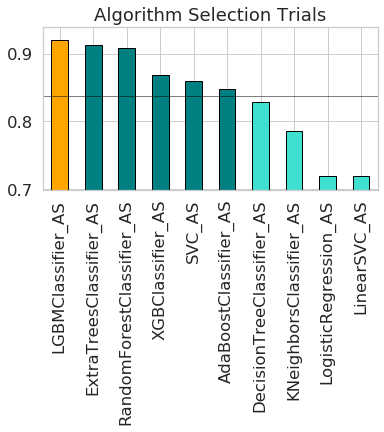

In [8]:
oracle_automl.visualize_algorithm_selection_trials()

In [9]:
###### load kaggle test dataset ######
kaggle_test_name = './d_vp_wo_num/kaggle-test_{}.csv'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.array(kaggle_test_df[id_col])
kaggle_test_df = kaggle_test_df.drop([id_col], axis=1)

print(kaggle_test_df.head())
kaggle_test_df.shape

         Date                                  Address  \
0  2008-06-11  4100 North Oak Park Avenue, Chicago,...   
1  2008-06-11  4100 North Oak Park Avenue, Chicago,...   
2  2008-06-11  4100 North Oak Park Avenue, Chicago,...   
3  2008-06-11  4100 North Oak Park Avenue, Chicago,...   
4  2008-06-11  4100 North Oak Park Avenue, Chicago,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991        

(116293, 10)

In [10]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

(116293,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
###### save kaggle prediction ######

kaggle_pred_name = './d_vp_wo_num/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

   Id  WnvPresent
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0
